In [1]:
from matplotlib import pyplot as plt
from skimage import img_as_float, img_as_ubyte
from skimage import data, io, filters, exposure
from skimage import util
import matplotlib as mp
import numpy as np
import math as mt

from pylab import *
from scipy import *

from ipywidgets import *

%matplotlib inline  

# ROZWAZANY PRZEDZIAL ([T0, T1])
signalScale = [0.0, 20.0]
# WYSWIETLANA SKALA NA WYKRESIE (DZIEDZINA CZASU)
timePlotXScale = [0.0, 20.0]
# WYSWIETLANA SKALA Y (DZIEDZINA CZASU)
timePloyYScale = [-3.0, 3.0] 

def changeX(left = 10, right = 20, speed = 10.0):
    def dynamicX(x):
        result = x
        if x >= left and x <= right:
            angle = (x - left)/(right-left)*(mt.pi)
            shift = (mt.cos(angle + mt.pi) + 1.0) / 2.0
            result = result + shift * speed
        if x > right:
            result = result + 1.0 * speed
        return result
    return dynamicX

def changeY(left = 5, right = 15, amplitude = 1.0):
    def dynamicY(y, x):
        result = y
        if x >= left and x <= right:
            angle = (x - left)/(right-left)*(2.0*mt.pi)
            shift = (mt.cos(angle + mt.pi) + 1.0) / 2.0
            result = y + shift * amplitude
        return result
    return dynamicY



# KLASA SCENARIO
# PO PROSTU LISTA SIGNALOW 
class Scenario(Widget):
    def __init__(self, signals):
        self.signals = signals
        
# KLASA SYGNAL - PROSTY(SIN)
class Signal:
    def __init__(self, amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue', 
                 changeX=changeX(-1,-1,0), changeY=changeY(-1,-1,0)):
        self.amplitude = amplitude
        self.frequency = frequency
        self.phase = phase
        self.yTranslation = yTranslation
        self.color = color
        self.changeX = changeX
        self.changeY = changeY
        
    #LISTA X, Y DLA ZADANEGO PRZEDZIALU I CZESTOTLIWOSCI PROBKOWANIA
    def getDataForRange(self, scale, samplingFrequency):
        x = np.arange(scale[0], scale[1], 1.0 / samplingFrequency)
        fs = lambda a: (self.amplitude * mt.sin(self.phase + self.changeX(a) * self.frequency * 2.0 * mt.pi) + self.yTranslation)
        y = [self.changeY(fs(a), a) for a in x ]
        return x, y

# WYLICZA WYNIKOWY SYGNAL ZE SKLADOWYCH
def getFinalSignal(signals, samplingFrequency):
    x = []
    y = []
    for s in signals:
        data = s.getDataForRange(signalScale, samplingFrequency)
        if len(x) == 0: x = data[0]
        if not y: y = [0] * len(x)
        for i in range(len(x)):
            y[i] = y[i] + data[1][i]
    return x, y
   
# --- RYSOWANIE WSZYSTKIEGO
# --- SINGLE - NA WEJSCIU PARAMETRY DLA POJEDYNCZEGO SYGNALU
# --- ALL - NA WEJSCIU SCENARIO



def plotSingle( amplitude = 1.0, 
                frequency = 0.5, 
                phase = 0.0, 
                yTranslation = 0.0,
                samplingFrequency = 10.0, 
                showComponents = True, 
                showFinal=False, 
                showFrequencyDomain=False, 
                showSymmetrical=False,
                showInverseFFT=False):
    
    scenario = Scenario([Signal(amplitude, frequency, phase, yTranslation)])
    plotAll(scenario, samplingFrequency, showComponents, showFinal, showFrequencyDomain, showSymmetrical, showInverseFFT)
    
def plotAllWithNoiseCancel(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            noiseThreshold = 10000.0,
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showInverseFFT=False,
            showSpectrogram=False,
            windowSize = 2.0,
            windowJump = 0.5):
    
    signals = scenario.signals
    
    # --- CONSTRUCT FIGURE AND SUBPLOTS ------------------------
    if showFrequencyDomain == True or showInverseFFT == True or showSpectrogram == True:
        column_width_pt = 1000.0
    else:
        column_width_pt = 500.0
        
    pt_per_inch = 72
    size = column_width_pt / pt_per_inch;
    height = 0.55
    
    total = 1
    if showFrequencyDomain == True: total = total + 1
    if showInverseFFT == True: total = total + 1
    if showSpectrogram == True: total = total + 1
    if total == 2: height = 0.37
    if total == 3: height = 0.37

    fig = plt.figure(1, figsize=(size, height * size))
    sub = fig.add_subplot(1, total, 1)
    if showFrequencyDomain == True:
        subFreq = fig.add_subplot(1, total, 2)
    if showInverseFFT == True:
        if (showFrequencyDomain == False):
            subIFFT = fig.add_subplot(1, total, 2)
        else:
            subIFFT = fig.add_subplot(1, total, 3)

    if showSpectrogram == True:
        subSpectr = fig.add_subplot(1, total, total)
    # ------------------------------------------------------
    # --- TIME DOMAIN --------------------------------------
            
    sub.set_xlabel('Time [s]')
    sub.set_ylabel('y = signal(x)')
    sub.grid('on', axis='both', color='gray', linewidth=1.25)
    
    sub.set_xlim(timePlotXScale)
    sub.set_ylim(timePloyYScale)
    
    if showComponents == True:
        for s in range(len(signals)):
            data = signals[s].getDataForRange(signalScale, samplingFrequency)
            #ŻEBY BYLO PRZEJRZYSCIEJ
            if (samplingFrequency < 8.0):
                sub.plot(data[0], data[1], marker='o', linestyle='---', color = signals[s].color)
            else:
                sub.plot(data[0], data[1], linestyle='-', color = signals[s].color)
    
    dataFinal = getFinalSignal(signals, samplingFrequency)
    if (showFinal):
        dataFinal = getFinalSignal(signals, samplingFrequency)
        sub.plot(dataFinal[0], dataFinal[1], linestyle='-', linewidth = 2.0, color = 'red')
        
    # ------------------------------------------------------
    # --- FREQUENCY DOMAIN --------------------------------------
    
    ind = np.arange(len(dataFinal[0]))  # the x locations for the groups   
    signal1 = np.fft.fft(dataFinal[1])
    signal2 = abs(signal1) /(0.5*len(dataFinal[0]))
    signal2[0] = signal2[0] / 2

    ffty = signal2
    freq = [v * samplingFrequency / len(dataFinal[0]) for v in ind]
    
    #signal1 = abs(signal1)/(0.5*n) 
    
    # USUWAMY PASMO
    signal3 = []
    for i in range(len(freq)):
        if noiseThreshold <= samplingFrequency / 2:
            if freq[i] <= samplingFrequency / 2 and freq[i] >= noiseThreshold:
                ffty[i] = 0.0
                signal1[i] = 0.0
            if freq[i] >= samplingFrequency / 2 and freq[i] <= samplingFrequency - noiseThreshold:
                ffty[i] = 0.0
                signal1[i] = 0.0
    
    if showSymmetrical == False:
        freq = freq[0:int(len(signal2)/ 2)]
        ffty = ffty[0:int(len(signal2)/ 2)]
 
    if showFrequencyDomain == True:
        
        subFreq.set_xlabel('Frequency [Hz]')
        subFreq.set_ylabel('Amplitude')
        subFreq.grid('on', axis='both', color='gray', linewidth=1.25)
            
        #TRANSFORM
        width = 0.15
        x = [v - width / 2 for v in freq]
        subFreq.set_ylim([0.0, 5.0])           
        barFreq = subFreq.bar(x, ffty,width, color='blue')
    
    # ------------------------------------------------------
    # --- INVERSE FFT --------------------------------------
    if showInverseFFT == True:
        subIFFT.set_xlabel('Time [s]')
        subIFFT.set_ylabel('y = signal(x)')
        subIFFT.grid('on', axis='both', color='gray', linewidth=1.25)
    
        subIFFT.set_xlim(timePlotXScale)
        subIFFT.set_ylim(timePloyYScale)
        
        signalIFFT = np.fft.ifft(signal1)
        
        
        subIFFT.plot(dataFinal[0], np.real(signalIFFT), linestyle='-', linewidth = 2.0, color = 'red')
   
    # ------------------------------------------------------
    # --- SHOW SPECTROGRAM --------------------------------------
    if showSpectrogram == True:
        subSpectr.set_xlabel('Time [s]')
        subSpectr.set_ylabel('Frequency [Hz]')
        subSpectr.grid('on', axis='both', color='gray', linewidth=1.25)
    
        xlabel = []
        data = []
        
        labels = []
        timesX = 0
        
        start = 0;
        startInDomain = 0
        windowSizeInDomain = windowSize * samplingFrequency
        jumpInDomain = windowJump * samplingFrequency
        
        timesX = windowSize/2
        
        yticks = []
        
        while startInDomain + windowSizeInDomain <= len(dataFinal[0]):
            
            labels.append(timesX)
            timesX += windowJump
            #labels.append(windowJump)
            xlabel.append(start)
            
            
            portion = []
            for i in range(int(startInDomain), int(startInDomain + windowSizeInDomain)):
                 portion.append(dataFinal[1][i])
                    
            if yticks == []:
                yticks = np.arange(0, len(portion), 1)
                    
            toAdd = abs(np.fft.fft(portion))/(0.5*len(portion))
            toAdd[0] = toAdd[0]/2
            if showSymmetrical == False:
                toAdd = toAdd[0:int(len(toAdd)/ 2)]
                
            data.append(toAdd)
            
            start += windowJump
            startInDomain += jumpInDomain
            
            
        npdata = np.array(data)
        npdata = np.transpose(npdata)
        
        
        print(timesX)
        xticks = np.arange(0, len(labels), 1)
        
        ylabels=[]
        for i in range(0, len(yticks)):
            freq=i/len(yticks) * samplingFrequency
            ylabels.append(freq)
   
        subSpectr.set_xticks(xticks)
        subSpectr.set_xticklabels(labels)
       
        subSpectr.set_yticks(yticks)
        subSpectr.set_yticklabels(ylabels)
       
    
        #subSpectr.set_xlim(0, len(npdata[0]))
        subSpectr.set_ylim(0, len(npdata))
        
     
    
        heatmap = subSpectr.pcolor(npdata)
        fig.colorbar(heatmap)
        
        
    plt.show()
    
def plotSpectrogram(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showSpectrogram=False,
            windowSize = 2.0,
            windowJump = 0.5):
    
    plotAllWithNoiseCancel(scenario, samplingFrequency, 1000000.0, showComponents, showFinal, 
                           showFrequencyDomain, showSymmetrical, False, showSpectrogram,
            windowSize,
            windowJump)
    
    
def plotAllWithNoiseCancelWithoutSpectrogram(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            noiseThreshold = 10000.0,
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showInverseFFT=False):
    
    plotAllWithNoiseCancel(scenario, samplingFrequency, noiseThreshold, showComponents, showFinal, 
                           showFrequencyDomain, showSymmetrical, showInverseFFT, showSpectrogram=False,
            windowSize = 2.0,
            windowJump = 0.5)
    
# --- WA - BEZ CZESCI PARAMETROW TRUE/FALSE - INACZEJ NIE WIEM JAK WYWALIC WIDGET Z INTERACT
# --- WIFFT - BEZ PARAMETROW IFFT - INACZEJ NIE WIEM JAK WYWALIC WIDGET Z INTERACT
def plotAll(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showInverseFFT=False): 
    
    plotAllWithNoiseCancel(scenario, samplingFrequency, 10000.0, showComponents, showFinal, 
                           showFrequencyDomain, showSymmetrical, showInverseFFT, showSpectrogram=False,
            windowSize = 10,
            windowJump = 3)

def plotSingleWithoutAll(   
    amplitude = 1.0, 
    frequency = 0.5, 
    phase = 0.0, 
    yTranslation = 0.0,
    samplingFrequency = 10.0):
    
    scenario = Scenario([Signal(amplitude, frequency, phase, yTranslation)])
    plotAll(scenario, samplingFrequency)

def plotSingleWIFFT(
    amplitude = 1.0, 
    frequency = 0.5, 
    phase = 0.0, 
    yTranslation = 0.0,
    samplingFrequency = 10.0, 
    showComponents = True, 
    showFinal=False, 
    showFrequencyDomain=False, 
    showSymmetrical=False):
    
    scenario = Scenario([Signal(amplitude, frequency, phase, yTranslation)])
    plotAll(scenario, samplingFrequency, showComponents, showFinal, showFrequencyDomain, showSymmetrical)
    
def plotAllWithoutAll(   
    scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
    samplingFrequency = 10.0, 
    showComponents = True, 
    showFinal=False):
    
    plotAll(scenario, samplingFrequency,showComponents, showFinal)

    
        



# SYGNAL W DZIEDZINIE CZASU

## Podstawowe cechy, czestotliwosc probkowania, nyquista

In [2]:
interact(plotSingleWithoutAll, amplitude=(0.5,2.5,0.1),
         frequency=(0.1, 2.0,0.1),phase = (-2.0 * mt.pi, 2.0*mt.pi, 0.25), 
         yTranslation = (-2.5, 2.5, 0.5), samplingFrequency=(0.25,10,0.25));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTEuMCwgZGVzY3JpcHRpb249dSdhbXBsaXR1ZGUnLCBtYXg9Mi41LCBtaW49MC41KSwgRmxvYXRTbGlkZXIodmFsdWU9MC7igKY=


$$u(t) = A \cdot sin(2\cdot \pi \cdot f_{0} \cdot t + \varphi) + y_{0}$$

Jaka musi być częstotliwość sygnału, aby jego przebieg się (jeden, pełen okres) się skończył w 5s?

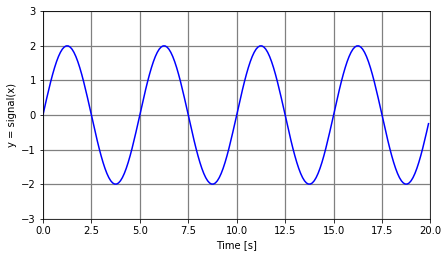

In [3]:
x = 0.2
plotSingleWithoutAll( 2, frequency = x, phase = 0, yTranslation = 0, samplingFrequency=10)

Jaka musi być częstotliwość sygnału, aby jego przebieg się (jeden, pełen) się skończył w 0.5s?

## Sumowanie sygnałow

In [4]:
sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 2.0, frequency = 0.25, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.25, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.0, frequency = 0.5, phase = mt.pi, yTranslation = 0.0, color = 'green') ])



scenarios = {"1. Przyklad": sc1 , "2. Wzmocnienie" : sc2, "3. Tlumienie" : sc3}
interact(plotAllWithoutAll, scenario=scenarios, samplingFrequency=(0.25,10,0.25));



aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnc2NlbmFyaW8nLCBvcHRpb25zPXsnMi4gV3ptb2NuaWVuaWUnOiBTY2VuYXJpbygpLCAnMS4gUHJ6eWtsYWQnOiDigKY=


# Sygnal w dziedzinie czestotliwosci

## Omowienie podstaw

In [5]:
#FFT
interact(plotSingleWIFFT, amplitude=(0.5,2.5,0.1),
         frequency=(0.0, 2.0,0.1),phase = (-2.0 * mt.pi, 2.0*mt.pi, 0.25), 
         yTranslation = (-2.5, 2.5, 0.5), samplingFrequency=(0.25,10,0.25));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTEuMCwgZGVzY3JpcHRpb249dSdhbXBsaXR1ZGUnLCBtYXg9Mi41LCBtaW49MC41KSwgRmxvYXRTbGlkZXIodmFsdWU9MC7igKY=


In [6]:
https://pl.wikipedia.org/wiki/Twierdzenie_Kotielnikowa-Shannona

SyntaxError: invalid syntax (<ipython-input-6-9668a40c9cc8>, line 1)

## Suma sygnalow w dziedzinie czasu a efekt w dziedzinie czestotliwosci.

## Odwrotne FFT

In [7]:

 
sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 2.0, frequency = 0.25, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.25, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.0, frequency = 0.5, phase = mt.pi, yTranslation = 0.0, color = 'green') ])

scenarios = {"1. Przyklad": sc1 , "2. Wzmocnienie" : sc2, "3. Tlumienie" : sc3}
interact(plotAll, scenario=scenarios, samplingFrequency=(0.25,10,0.25));




aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnc2NlbmFyaW8nLCBvcHRpb25zPXsnMi4gV3ptb2NuaWVuaWUnOiBTY2VuYXJpbygpLCAnMS4gUHJ6eWtsYWQnOiDigKY=


In [8]:
x = np.arange(0, 2 * 2*np.pi, 0.1)
y = np.sin(x)
print(y)

[ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99749499  0.9995736   0.99166481
  0.97384763  0.94630009  0.90929743  0.86320937  0.8084964   0.74570521
  0.67546318  0.59847214  0.51550137  0.42737988  0.33498815  0.23924933
  0.14112001  0.04158066 -0.05837414 -0.15774569 -0.2555411  -0.35078323
 -0.44252044 -0.52983614 -0.61185789 -0.68776616 -0.7568025  -0.81827711
 -0.87157577 -0.91616594 -0.95160207 -0.97753012 -0.993691   -0.99992326
 -0.99616461 -0.98245261 -0.95892427 -0.92581468 -0.88345466 -0.83226744
 -0.77276449 -0.70554033 -0.63126664 -0.55068554 -0.46460218 -0.37387666
 -0.2794155  -0.1821625  -0.0830894   0.0168139   0.1165492   0.21511999
  0.31154136  0.40484992  0.49411335  0.57843976  0.6569866   0.72896904
  0.79366786  0.85043662  0.8987081   0.93799998  0.96791967  0.98816823
  0.99854335  0.99894134  0.98935825  0.96988981  0

In [9]:
yp = np.fft.ifft(np.fft.fft(y))
print(y)

[ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691  0.84147098  0.89120736
  0.93203909  0.96355819  0.98544973  0.99749499  0.9995736   0.99166481
  0.97384763  0.94630009  0.90929743  0.86320937  0.8084964   0.74570521
  0.67546318  0.59847214  0.51550137  0.42737988  0.33498815  0.23924933
  0.14112001  0.04158066 -0.05837414 -0.15774569 -0.2555411  -0.35078323
 -0.44252044 -0.52983614 -0.61185789 -0.68776616 -0.7568025  -0.81827711
 -0.87157577 -0.91616594 -0.95160207 -0.97753012 -0.993691   -0.99992326
 -0.99616461 -0.98245261 -0.95892427 -0.92581468 -0.88345466 -0.83226744
 -0.77276449 -0.70554033 -0.63126664 -0.55068554 -0.46460218 -0.37387666
 -0.2794155  -0.1821625  -0.0830894   0.0168139   0.1165492   0.21511999
  0.31154136  0.40484992  0.49411335  0.57843976  0.6569866   0.72896904
  0.79366786  0.85043662  0.8987081   0.93799998  0.96791967  0.98816823
  0.99854335  0.99894134  0.98935825  0.96988981  0

## Fajne zastosowanie FFT i iFFT

In [10]:

l1 = [
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.5, frequency = 0.25, phase = 0.5 * mt.pi, yTranslation = 0.0, color = 'green'),
        Signal(amplitude = 0.5, frequency = 0.4, phase = 1.25 * mt.pi, yTranslation = 0.0, color = 'orange')]

l2 = [
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.5, frequency = 0.25, phase = 0.5 * mt.pi, yTranslation = 0.0, color = 'green'),
        Signal(amplitude = 0.5, frequency = 0.4, phase = 1.25 * mt.pi, yTranslation = 0.0, color = 'orange')]

for i in range(50):
    amplitude = 0.05 + random.random() * 0.15
    #Round - Uniknięcie błędów numerycznych, co sie stanie po usunieciu round?
    # frequency = round(1.0 + random.random() * 3.0, 1)
    frequency = round(1.0 + random.random() * 3.0, 1) 
    phase = random.random() * mt.pi
    color = 'black'
    l2.append(Signal(amplitude, frequency, phase, 0.0, color))

sc1 = Scenario(l1)
sc2 = Scenario(l2)

scenarios = {"1. Przyklad": sc1, "2. Noise": sc2 }
interact(plotAllWithNoiseCancelWithoutSpectrogram, scenario=scenarios, noiseThreshold=6.0, samplingFrequency=(0.25,10,0.25));


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnc2NlbmFyaW8nLCBvcHRpb25zPXsnMS4gUHJ6eWtsYWQnOiBTY2VuYXJpbygpLCAnMi4gTm9pc2UnOiBTY2VuYXLigKY=


In [11]:
a = np.eye(4)
print(a)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [12]:
fd = np.fft.fft2(a)
print(fd)

[[4.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 4.+0.j]
 [0.+0.j 0.+0.j 4.+0.j 0.+0.j]
 [0.+0.j 4.+0.j 0.+0.j 0.+0.j]]


In [13]:
d = np.fft.ifft2(fd)
print(d)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [14]:
d = np.fft.ifft2(fd)
print(np.abs(d))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


/usr/lib/python2.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


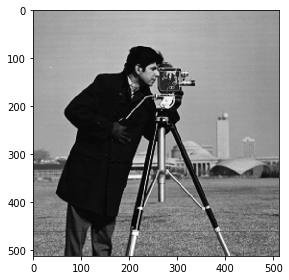

In [15]:
cam = img_as_float(data.camera())
io.imshow(cam)

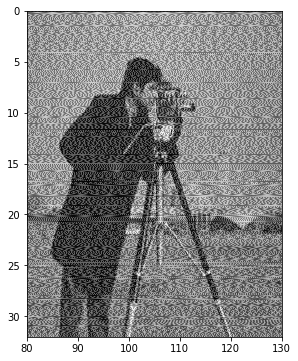

In [16]:
#imgProc = util.random_noise(cam, mode='s&p', amount=0.3)  
#imgProc = util.random_noise(cam, mode='gaussian', mean=0, var=0.2)

imgProc = np.empty_like(cam)
imgProc[:] = cam

for y in range(0, imgProc.shape[0]):
    phi = (random.random() * 100)
    freq = 0.2 + random.random() * 0.5
    for x in range(0, imgProc.shape[1]):
        ab = 0.3 * sin(2*np.pi * freq * x + phi)
        #imgProc[y][x] = ab
        imgProc[y][x] += ab


#io.imshow(imgProc,cmap='gray', interpolation='none')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(imgProc,cmap='gray', interpolation='none', extent=[80,130,32,0])
ax.set_aspect(2) # you may also use am.imshow(..., aspect="auto") to restore the

In [17]:
fd = np.fft.fft2(imgProc)

In [18]:
fdp = np.abs(fd)
print(fdp)

[[121625.68060788  19779.47917354   8048.11659086 ...   4406.75376625
    8048.11659086  19779.47917354]
 [ 17094.63350023  15215.64276767  10040.32746322 ...   2526.0532279
    4131.85875242   4931.74745464]
 [  8362.07488042   4960.12060582   2314.04073329 ...   2597.38304923
    1506.37770947   3260.83435169]
 ...
 [  2967.63355691   1854.26952544   2254.59760204 ...   2602.73671754
    2285.53692106   1365.29223662]
 [  8362.07488042   3260.83435169   1506.37770947 ...   2437.27194818
    2314.04073329   4960.12060582]
 [ 17094.63350023   4931.74745464   4131.85875242 ...   3005.7665659
   10040.32746322  15215.64276767]]


0.0007462865941962768


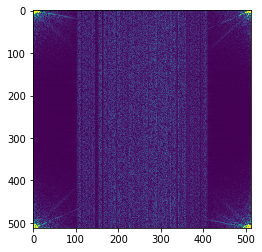

In [19]:
m = np.max(fdp)
copy = fdp / m
print(np.mean(copy))
norm = (copy - 0) / (0.01 - 0)
norm[norm > 1] = 1
norm[norm < 0] = 0
plt.imshow(norm)

(512, 512)


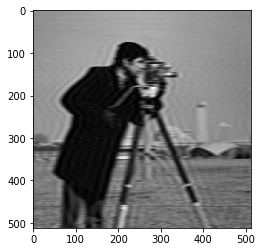

In [20]:
print(fd.shape)
w = fd.shape[1]
h = fd.shape[0]

prop = 0.9
copy = np.empty_like(fd)
copy[:] = fd

#copy[int(h/2 - h/2 * prop): int(h/2 + h/2* prop), int(w/2 - w/2 * prop): int(w/2 + w/2* prop)] = 0
copy[0:h, int(w/2 - w/2 * prop): int(w/2 + w/2* prop)] = 0



new_img = np.fft.ifft2(copy)
#print(new_img)
plt.imshow(np.abs(new_img),cmap='gray')

Pojedynczy sygnal - zmienny w czasie

In [21]:


sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(5,15,10))])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeY=changeY(5,15,1))])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(10,20,10), changeY=changeY(0,10,1))])


scenarios = {"1. Zmienna czestotliwosc": sc1 , "2. Zmiena amplituda/wychylenie" : sc2, "3. Mix" : sc3}
interact(plotAll, scenario=scenarios, samplingFrequency=(0.25,10,0.25));




aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnc2NlbmFyaW8nLCBvcHRpb25zPXsnMy4gTWl4JzogU2NlbmFyaW8oKSwgJzEuIFptaWVubmEgY3plc3RvdGxpd2/igKY=


## Spectrogram

In [22]:

sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(5,15,10))])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeY=changeY(5,15,1))])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(10,20,10), changeY=changeY(0,10,1))])

scenarios = {"1. Czestotliwosc": sc1, "2. Amplituda": sc2, "3. Mix": sc3   }
interact(plotSpectrogram, scenario=scenarios, samplingFrequency=(0.25,10,0.25), windowSize=(4.0,10.0,0.25), 
         windowJump=(0.25,2.0,0.25));


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnc2NlbmFyaW8nLCBvcHRpb25zPXsnMS4gQ3plc3RvdGxpd29zYyc6IFNjZW5hcmlvKCksICczLiBNaXgnOiBTY2XigKY=


In [23]:
https://pl.wikipedia.org/wiki/Okno_czasowe

SyntaxError: invalid syntax (<ipython-input-23-65304ffbdbc9>, line 1)

In [ ]:
v = [0, 1, 0, -1]
res = np.fft.fft(v)
print(res)

In [ ]:
v = [0, 4, 0, -4]
res = np.fft.fft(v)
print(res)

In [ ]:
v = [0, 4, 0, -4]
res = np.fft.fft(v)
print(res)

In [ ]:
l = 2**0.5/2
v = [0, l, 1, l, 0, -l, -1, -l]
print(v)
res = np.fft.fft(v)
print(res)

In [ ]:
v = [1, 2, 1, 0]
res = np.fft.fft(v)
print(res)